In [2]:
!pip install wfdb

     |████████████████████████████████| 133kB 5.7MB/s 


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import wfdb
from random import shuffle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!wget -r -N -c -np https://physionet.org/files/ludb/1.0.0/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Length: 116 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v4’

physionet.org/files 100%[===================>]     116  --.-KB/s    in 0s      

2021-04-20 19:10:04 (13.1 MB/s) - ‘physionet.org/files/ludb/1.0.0/67.atr_v4’ saved [116/116]

--2021-04-20 19:10:04--  https://physionet.org/files/ludb/1.0.0/67.atr_v5
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 116 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v5’

physionet.org/files 100%[===================>]     116  --.-KB/s    in 0s      

2021-04-20 19:10:05 (26.4 MB/s) - ‘physionet.org/files/ludb/1.0.0/67.atr_v5’ saved [116/116]

--2021-04-20 19:10:05--  https://physionet.org/files/ludb/1.0.0/67.atr_v6
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 110 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v6’

physionet.org/files 100%[=======

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import re
import wfdb
from wfdb import processing

data_dir = Path('/content/physionet.org/files/ludb/1.0.0')

num_records = 200
records = []
for i in range(1,num_records+1):
    record = wfdb.io.rdrecord(f'{data_dir}/{i}')
#    age = 99 if record.comments[0][7:] == '>89' else int(record.comments[0][7:])
    data = dict()
     #{'id': i,
#            'age(10)' : age //10 * 10, 
#            'sex':record.comments[1][-1],
#            'dignosis':record.comments[3:]}
    cols = ['i', 'ii',  'iii',  'avr',  'avl',  'avf',  'v1',  'v2',  'v3',  'v4',  'v5',  'v6']
    for col, j in zip(cols, range(12)):
        ann = wfdb.rdann(f'{data_dir}/{i}', f'atr_{col}')
        data[col] = {'signal':record.p_signal[:, j], 'anno': ann.__dict__['symbol'], 'anno_idx': ann.__dict__['sample']}
    records.append(data)

In [13]:
num_records = 200
records = []
for i in range(1,num_records+1):
    record = wfdb.io.rdrecord(f'{data_dir}/{i}')
    age = 99 if record.comments[0][7:] == '>89' else int(record.comments[0][7:])
    data = {'id': i,
            'age(10)' : age //10 * 10, 
            'sex':record.comments[1][-1],
            'dignosis':record.comments[3:]}
    cols = ['i', 'ii',  'iii',  'avr',  'avl',  'avf',  'v1',  'v2',  'v3',  'v4',  'v5',  'v6']
    for col, j in zip(cols, range(12)):
        ann = wfdb.rdann(f'{data_dir}/{i}', f'atr_{col}')
        data[col] = {'singal':record.p_signal[:, j], 'anno': ann.__dict__['symbol'], 'anno_idx': ann.__dict__['sample']}
    records.append(data)

In [14]:
data

{'age(10)': 50,
 'avf': {'anno': ['(',
   'N',
   ')',
   '(',
   't',
   ')',
   '(',
   'p',
   ')',
   '(',
   'N',
   ')',
   '(',
   't',
   ')',
   '(',
   'p',
   ')',
   '(',
   'N',
   ')',
   '(',
   't',
   ')',
   '(',
   'p',
   ')',
   '(',
   'N',
   ')',
   '(',
   't',
   ')',
   '(',
   'p',
   ')',
   '(',
   'N',
   ')',
   '(',
   't',
   ')',
   '(',
   'p',
   ')',
   '(',
   'N',
   ')',
   '(',
   't',
   ')',
   '(',
   'p',
   ')',
   '(',
   'N',
   ')',
   '(',
   't',
   ')',
   '(',
   'p',
   ')',
   '(',
   'N',
   ')',
   '(',
   't',
   ')',
   '(',
   'p',
   ')',
   '(',
   'N',
   ')'],
  'anno_idx': array([ 510,  530,  563,  620,  673,  715,  924,  945,  963,  992, 1014,
         1042, 1106, 1159, 1202, 1400, 1424, 1442, 1474, 1492, 1521, 1587,
         1635, 1677, 1867, 1893, 1909, 1940, 1960, 1993, 2055, 2102, 2144,
         2346, 2371, 2386, 2413, 2432, 2459, 2523, 2576, 2616, 2822, 2839,
         2854, 2885, 2908, 2940, 3004, 3052, 3092, 3286,

In [16]:
print(records)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
os.makedirs('/content/npy') ## npy 파일들을 저장할 디렉터리 경로 설정

In [ ]:
data_info = {'p': 0 , 'N' : 0 , 't' : 0}


for i in range(200):
  
  # print(f'{i+1}번째 npy 저장 완료')
  a = 0

  # 12개의 lead에 대해 길이 600의 ECG 분할
  
  lead = 'ii'

  pqrst_label = np.array(records[i][lead]['anno'])
  pqrst_point = np.array(records[i][lead]['anno_idx'])
  lead_signal = records[i][lead]['signal']

  for w in data_info.keys():
    start_points = np.where(np.array(pqrst_label) == w)[0]-1 
    end_points = np.where(np.array(pqrst_label) == w)[0]+1 

    start_index = pqrst_point[start_points]
    end_index = pqrst_point[end_points]

    interval = end_index - start_index
    
    if not len(interval) == 0:
      avg_interval = round(sum(interval) / len(interval), 2)
    else : avg_interval = 0

    data_info[w] += avg_interval
    
p = round(data_info['p']/(200*500), 4)*1000
q = round(data_info['N']/(200*500), 4)*1000
t = round(data_info['t']/(200*500), 4)*1000

print(f'200개의 ECG에서 P파 주기는 평균 {p}ms입니다.')
print(f'200개의 ECG에서 QRS파 주기는 평균 {q}ms입니다.')
print(f'200개의 ECG에서 T파 주기는 평균 {t}ms입니다.')

200개의 ECG에서 P파 주기는 평균 97.4ms입니다.
200개의 ECG에서 QRS파 주기는 평균 92.8ms입니다.
200개의 ECG에서 T파 주기는 평균 183.5ms입니다.


In [ ]:
wave_length = 600 

for i in range(50):
  print(f'{i+1}번째 npy 저장 완료')
  a = 0

  # 12개의 lead에 대해 길이 600의 ECG 분할
  for lead in cols:
    pqrst_label = np.array(records[i][lead]['anno'])
    pqrst_point = np.array(records[i][lead]['anno_idx'])
    lead_signal = records[i][lead]['signal']

    start_points = np.where(np.array(pqrst_label)=='p')[0]-1 

    # P파 시작점으로 학습할 데이터 npy를 600길이로 만들기
    for j,start_point in enumerate(start_points):
        start_index = pqrst_point[start_point]
        seg_signal = lead_signal[start_index:start_index+wave_length] 

        pqrst_index = pqrst_point[(pqrst_point>=start_index)&(pqrst_point<start_index+wave_length)] 

        # segment 안에 존재하는 pqrst list
        seg_labels = pqrst_label[np.isin(pqrst_point,pqrst_index)] 
        # 해당 pqrst의 segment상 인덱스
        seg_labels_index = pqrst_index - start_index

        unet_label_list = list()
        unet_label_list.append(seg_signal)
        for pqrst in ['p','N','t']:
            # 'p','N','t'의 인덱스
            pqrst_peak = np.where(seg_labels==pqrst)[0]

            # seg_labels에서 onset offset 인덱스

            onset_pqrst = pqrst_peak-1
            offset_pqrst = pqrst_peak+1

            mask = np.zeros(wave_length) 
            for onset,offset in zip(onset_pqrst,offset_pqrst[:len(onset_pqrst)]):
                try:
                    onset_index = seg_labels_index[onset]
                    offset_index = seg_labels_index[offset]
                    mask[onset_index:offset_index] =1
                except IndexError:
                    pass

            unet_label_list.append(mask)
        
        if unet_label_list[-1].sum()!=0:
            # T파까지 레이블이 있을 경우에 저장
          last_mask = np.ones(wave_length)-(unet_label_list[1]+unet_label_list[2]+unet_label_list[3]) # none of above 마스크
          unet_label_list.append(last_mask)
          
          np.save(f'/content/npy/{i+1}_{a+j}{lead}',np.array(unet_label_list))
        a = a + j + 1

1번째 npy 저장 완료
2번째 npy 저장 완료
3번째 npy 저장 완료
4번째 npy 저장 완료
5번째 npy 저장 완료
6번째 npy 저장 완료
7번째 npy 저장 완료
8번째 npy 저장 완료
9번째 npy 저장 완료
10번째 npy 저장 완료
11번째 npy 저장 완료
12번째 npy 저장 완료
13번째 npy 저장 완료
14번째 npy 저장 완료
15번째 npy 저장 완료
16번째 npy 저장 완료
17번째 npy 저장 완료
18번째 npy 저장 완료
19번째 npy 저장 완료
20번째 npy 저장 완료
21번째 npy 저장 완료
22번째 npy 저장 완료
23번째 npy 저장 완료
24번째 npy 저장 완료
25번째 npy 저장 완료
26번째 npy 저장 완료
27번째 npy 저장 완료
28번째 npy 저장 완료
29번째 npy 저장 완료
30번째 npy 저장 완료
31번째 npy 저장 완료
32번째 npy 저장 완료
33번째 npy 저장 완료
34번째 npy 저장 완료
35번째 npy 저장 완료
36번째 npy 저장 완료
37번째 npy 저장 완료
38번째 npy 저장 완료
39번째 npy 저장 완료
40번째 npy 저장 완료
41번째 npy 저장 완료
42번째 npy 저장 완료
43번째 npy 저장 완료
44번째 npy 저장 완료
45번째 npy 저장 완료
46번째 npy 저장 완료
47번째 npy 저장 완료
48번째 npy 저장 완료
49번째 npy 저장 완료
50번째 npy 저장 완료


In [ ]:
## 파일이 해당 경로에 잘 저장되었는지, 리드 별로 얼마나 저장되었는지 확인
npy_files = os.listdir('/content/npy/')
print(f'저장된 파일은 총 {len(npy_files)}개 입니다.')

count_lead = list( 0 for i in range(len(cols)) )
total = 0

for i in range(len(cols)):
  for j in range(len(npy_files)):
    if cols[i] in npy_files[j]:
      if 'i' in cols[i]:
        if len(cols[i]) == npy_files[j].count('i'):
          count_lead[i] += 1
          total += 1
      else: 
        count_lead[i] += 1
        total += 1
  print(f'lead {cols[i]} : {count_lead[i]}개')

print('\n',f'12-lead 총 {total}개 확인')

저장된 파일은 총 3308개 입니다.
lead i : 276개
lead ii : 276개
lead iii : 276개
lead avr : 276개
lead avl : 276개
lead avf : 276개
lead v1 : 276개
lead v2 : 276개
lead v3 : 276개
lead v4 : 272개
lead v5 : 276개
lead v6 : 276개

 12-lead 총 3308개 확인


180번째 그래프 확인


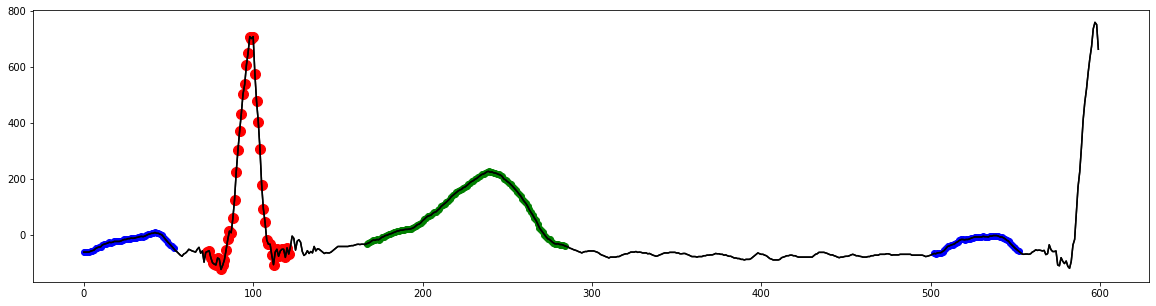

In [ ]:
# npy파일 로드
npy_df = pd.DataFrame([[file.split('_')[0],file] for file in npy_files],columns=['ID','file'])
npy_df = npy_df.sort_values(['ID','file'])
npy_df['filepath'] = npy_df.file.apply(lambda x : os.path.join(f'/content/npy/',x))

# 무작위의 N번째 데이터 확인
N = np.random.randint(0,len(npy_files))
print(f'{N}번째 그래프 확인')
seg = np.load(os.path.join('/content/npy/',npy_df.file.tolist()[N]))

plt.figure(figsize=(20, 5))
plt.plot(seg[0], 'black')

# 해당 ECG data를 plot하는데 wave별로 다른 색상으로 표시
for i in range(len(seg[0])):
  if i in np.where(seg[1]==1)[0]:
    plt.scatter(i,seg[0][i], c='blue')
  if i in np.where(seg[2]==1)[0]:
    plt.scatter(i,seg[0][i],c='red', s=100)
  if i in np.where(seg[3]==1)[0]:
    plt.scatter(i,seg[0][i],c='green')
plt.plot(seg[0], 'black')

In [3]:
import numpy as np

npyfile = np.load('/content/drive/MyDrive/2020-2 Deep Learning/팀프로젝트/2_0.npy')
npyfile

array([[-59.99608508, -59.99608508, -56.99464962, ...,  -7.99295315,
         45.00521989,  15.00717735],
       [  1.        ,   1.        ,   1.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   1.        ,
          1.        ,   1.        ]])

In [ ]:
# 추출한 파일 경로에 있는 데이터에서 ECG data와 해당 wave 정보를 numpy로 반환해주는 seg_data 클래스 정의
class seg_data(Dataset):
    def __init__(self,file_df):
        self.filepath = file_df.filepath.tolist()
        
    def __len__(self):
        return len(self.filepath)
    
    def __getitem__(self,item):
        try:
            seg = np.load(self.filepath[item])
            ecg = seg[0]
            mask_arr = seg[1:,:]
        except:       
            print(self.filepath[item])
        
        return torch.from_numpy(ecg).unsqueeze(0),torch.from_numpy(mask_arr)

In [ ]:
# 시계열 데이터처리에 많이 사용되는 1D convolution을 이용한 CBR_1D 클래스 정의
'''
    각각의 Parameter들은 다음과 같은 의미를 갖는다.
      in_channels: input의 feature dimension
      out_channels: 내가 output으로 내고싶은 dimension
      kernel_size: time step을 얼마만큼 볼 것인가(=frame size = filter size)
      stride: kernel을 얼마만큼씩 이동하면서 적용할 것인가 (Default: 1)      
      padding: 한 쪽 방향으로 얼마만큼 padding할 것인가 (그 만큼 양방향으로 적용) (Default: 0)      
      bias: bias term을 둘 것인가 안둘 것인가 (Default: True)     
'''
class CBR_1D(nn.Module):
    def __init__(self,in_channels,out_channels,kernel=9,stride=1,padding=4):
        super().__init__()
        self.seq_list = [
        nn.Conv1d(in_channels,out_channels,kernel,stride,padding,bias=False),
        nn.BatchNorm1d(out_channels),
        nn.ReLU()]
        
        self.seq = nn.Sequential(*self.seq_list)
        
    def forward(self,x):
        return self.seq(x)

In [ ]:
# 기존의 이미지나 영상 처리분야에서 특정이미지에 대한 단순한 Label을 지정하는 Unet architecture
'''
  [Unet idea]
  Mapping 된 출력 결과물로부터 decoding 되는 매 순간마다, 해당 layer와 수평관계에 존재하는 encoding layer의 출력 결과물을 Concatenation 한다.
  이때, concat은 Channel 차원을 기준으로 하기 때문에 두장의 사진이 서로 겹쳐져 있는 형태로 연결됨.

  Convolution 과정을 통해 이것들을 서로 합치고, 이 과정에서 Pixel 단위로 서로 같은 위치에 있는 값이 더욱 잘 특정되어지게 된다.
  이렇게 출력된 결과물을 또 한번 Upsampling을 진행하여 압축되어 있던 결과물을 풀어 다시한번 concatenation을 진행함.

  Encoding 영역 : enc와 dec 영역이 서로 수평관계에 있을 경우 Encoding 영역에서 출력된 결과물을 Decoding 영역과 Concat해줌.
  Decoding 영역 : 여러 입력 평면으로 구성된 입력 이미지에 1D transpose Convolution 연산자를 적용하는 Up-Sampling(Up-Conv)영역 (=> ConvTranspose1d)
'''
class Unet_1D(nn.Module):
    def __init__(self,class_n,layer_n):
        super().__init__()
        
        ### ------- encoder -----------
        self.enc1_1 = CBR_1D(1,layer_n)
        self.enc1_2 = CBR_1D(layer_n,layer_n)
        self.enc1_3 = CBR_1D(layer_n,layer_n)
        
        self.enc2_1 = CBR_1D(layer_n,layer_n*2)
        self.enc2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.enc3_1 = CBR_1D(layer_n*2,layer_n*4)
        self.enc3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.enc4_1 = CBR_1D(layer_n*4,layer_n*8)
        self.enc4_2 = CBR_1D(layer_n*8,layer_n*8)
         
        ### ------- decoder -----------
        self.upsample_3 = nn.ConvTranspose1d(layer_n*8,layer_n*8,kernel_size=8,stride=2,padding=3)
        self.dec3_1 = CBR_1D(layer_n*4+layer_n*8,layer_n*4)
        self.dec3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.upsample_2 = nn.ConvTranspose1d(layer_n*4,layer_n*4,kernel_size=8,stride=2,padding=3)
        self.dec2_1 = CBR_1D(layer_n*2+layer_n*4,layer_n*2)
        self.dec2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.upsample_1 = nn.ConvTranspose1d(layer_n*2,layer_n*2,kernel_size=8,stride=2,padding=3)
        self.dec1_1 = CBR_1D(layer_n*1+layer_n*2,layer_n*1)
        self.dec1_2 = CBR_1D(layer_n*1,layer_n*1)
        self.dec1_3 = CBR_1D(layer_n*1,class_n)
        self.dec1_4 = CBR_1D(class_n,class_n)
        
    def forward(self,x):
        
        enc1 = self.enc1_1(x)
        enc1 = self.enc1_2(enc1)
        enc1 = self.enc1_3(enc1)
        
        enc2 = nn.functional.max_pool1d(enc1,2)
        enc2 = self.enc2_1(enc2)
        enc2 = self.enc2_2(enc2)
        
        enc3 = nn.functional.max_pool1d(enc2,2)
        enc3 = self.enc3_1(enc3)
        enc3 = self.enc3_2(enc3)
        
        enc4 = nn.functional.max_pool1d(enc3,2)        
        enc4 = self.enc4_1(enc4)
        enc4 = self.enc4_2(enc4)
        
        dec3 = self.upsample_3(enc4)
        dec3 = self.dec3_1(torch.cat([enc3,dec3],dim=1))
        dec3 = self.dec3_2(dec3)
        
        dec2 = self.upsample_2(dec3)
        dec2 = self.dec2_1(torch.cat([enc2,dec2],dim=1))
        dec2 = self.dec2_2(dec2)
        
        dec1 = self.upsample_1(dec2)
        dec1 = self.dec1_1(torch.cat([enc1,dec1],dim=1))
        dec1 = self.dec1_2(dec1)
        dec1 = self.dec1_3(dec1)
        out = self.dec1_4(dec1)
        
        return out

In [ ]:
# 같은 ID의 ECG를 학습시키기 위해 ID 섞기
ID_number = list(set(npy_df.ID.tolist()))
shuffle(ID_number)

# train:valid :test = 2:1:1 
train_set = ID_number[:int(len(ID_number)*(1/2))]
valid_set = ID_number[int(len(ID_number)*(1/2)):int(len(ID_number)*(3/4))]
test_set = ID_number[int(len(ID_number)*(3/4)):]


# 같은 ID는 train set와 test set 동시에 속할 수 없음
train_npy = npy_df.query("ID in @train_set")
valid_npy = npy_df.query("ID in @valid_set")
test_npy = npy_df.query("ID in @test_set")

train_data = seg_data(train_npy)
valid_data = seg_data(valid_npy)
test_data = seg_data(test_npy)

train_loader = DataLoader(train_data,batch_size=256,shuffle=True,drop_last=True)
valid_loader = DataLoader(valid_data,batch_size=256)
test_loader = DataLoader(test_data,batch_size=256)

In [ ]:
# 하이퍼 파라미터
device = 'cuda:0'
class_n = 2
epochs = 150
lr = 0.001

In [ ]:
# 모델 구성
from torch.optim.lr_scheduler import CosineAnnealingLR,StepLR,ReduceLROnPlateau
model = Unet_1D(4,6).double().to(device)
optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optim,'min',patience=10,factor=0.8,min_lr=1e-8)
loss_f = torch.nn.BCEWithLogitsLoss()

트레이닝 시작.
10% 완료. Train loss :0.674 Valid loss : 0.685
20% 완료. Train loss :0.603 Valid loss : 0.617
30% 완료. Train loss :0.582 Valid loss : 0.606
40% 완료. Train loss :0.572 Valid loss : 0.598
50% 완료. Train loss :0.564 Valid loss : 0.598
60% 완료. Train loss :0.56 Valid loss : 0.602
70% 완료. Train loss :0.555 Valid loss : 0.599
80% 완료. Train loss :0.55 Valid loss : 0.601
90% 완료. Train loss :0.547 Valid loss : 0.604
100% 완료. Train loss :0.545 Valid loss : 0.599


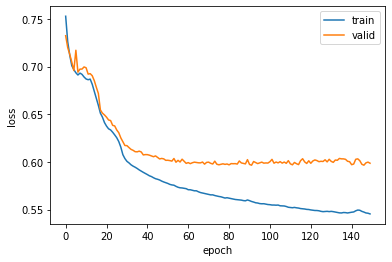

In [ ]:
# 학습 과정
train_loss_list = []
valid_loss_list = []

for epoch in range(epochs):
  model.train()
  train_loss = 0
  train_output = list()
  for i, (x,y) in enumerate(train_loader):
      optim.zero_grad()
      
      x_output = model(x.to(device))
      loss = loss_f(x_output,y.to(device))
      
      loss.backward()
      optim.step()
      
      train_loss += loss.cpu().item()/len(train_loader)
      y_model = F.softmax(x_output,1).detach().cpu().numpy().argmax(axis=1)
      train_output.extend(list(y_model))
       
  train_loss_list.append(train_loss)

  valid_loss = 0
  for i,(x,y) in enumerate(valid_loader):

      x_output = model(x.to(device))
      y_model = F.softmax(x_output,1).detach().cpu().numpy().argmax(axis=1)
      
      loss = loss_f(x_output,y.to(device))
      valid_loss+=loss.cpu().item()/len(valid_loader)
  valid_loss_list.append(valid_loss)

  if epoch == 0:
    print('트레이닝 시작.')
  if 100 * (epoch+1)/epochs % 10 == 0:
    print(f'{int(100 * (epoch+1)/epochs)}% 완료. Train loss :{round(train_loss,3)} Valid loss : {round(valid_loss,3)}')

# loss 변화 그래프
x = [_ for _ in range(epochs)]

plt.plot(x, train_loss_list, label='train')
plt.plot(x, valid_loss_list, label='valid')
plt.legend(loc='upper right')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
 # 테스트 셋으로 성능평가

eval_ecgs = list()
eval_labels = list()
eval_outputs = list()

for i, (x,y) in enumerate(test_loader):
  
  model.eval()
  x_output = model(x.to(device))
  y_model = F.softmax(x_output,1).detach().cpu().numpy().argmax(axis=1)

  eval_outputs.extend(list(y_model))
  eval_ecgs.extend(list(x.cpu().detach().numpy().squeeze(1)))
  eval_labels.extend(list(y.cpu().detach().numpy()))

In [ ]:
from sklearn.metrics import accuracy_score

total_acc = []
  
for i in range(len(eval_labels)):
  input = np.zeros(wave_length)

  label = eval_labels[i]
  output = eval_outputs[i]

  # P/QRS/T/정상 4가지 클래스 전부 예측을 전부 예측했고 전체 범위에서 얼마나 비슷한가 확인해보기
  p = (output == 0)
  N = (output == 1)
  t = (output == 2)
  r = (output == 3)

  for i in range(len(label)):
    input += label[i]*i

  # print(accuracy_score(input, output))
  total_acc.append(accuracy_score(input, output)) # 원래 인풋 레이블과 클래스 개수 비교해보기

accuracy = sum(total_acc) / len(total_acc)
print(f'전체적으로 {round(accuracy*100,2)}% 정도 정확히 예측')

전체적으로 91.76% 정도 정확히 예측


총 840개 중, 366번째 테스트 샘플


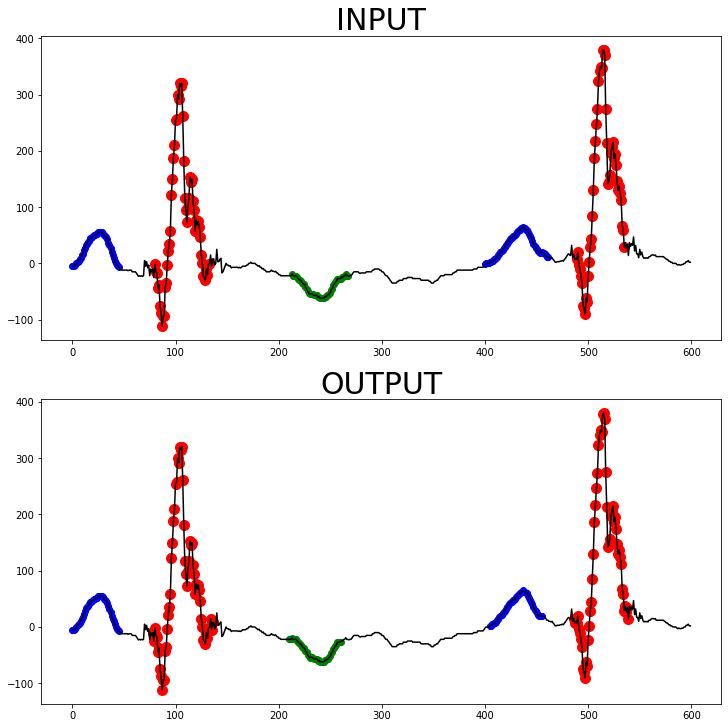

In [ ]:
# 시각적으로 성능 확인

sample = np.random.randint(0,len(eval_ecgs))
print(f'총 {len(eval_ecgs)}개 중, {sample}번째 테스트 샘플')
ecg = eval_ecgs[sample]
label = eval_labels[sample]
output = eval_outputs[sample]

p = (output == 0)
N = (output == 1)
t = (output == 2)
r = (output == 3)

fig,graph = plt.subplots(2,1,figsize=(10,10),constrained_layout=True)

graph[0].plot(ecg, 'black')
graph[0].set_title('INPUT',size=30)
for i in range(len(ecg)):
  if i in np.where(label[0]==1)[0]:
    graph[0].scatter(i,ecg[i], c='blue')
  if i in np.where(label[1]==1)[0]:
    graph[0].scatter(i,ecg[i],c='red', s=100)
  if i in np.where(label[2]==1)[0]:
    graph[0].scatter(i,ecg[i],c='green')

graph[1].plot(ecg, 'black')
graph[1].set_title('OUTPUT',size=30)
for i in range(len(ecg)):
  if p[i]:
    graph[1].scatter(i,ecg[i], c='blue')
  if N[i]:
    graph[1].scatter(i,ecg[i],c='red', s=100)
  if t[i]:
    graph[1].scatter(i,ecg[i],c='green') 